# 1. Import libraries and data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
%matplotlib inline

We import our data using *.read_csv()* method and we also add a parameter "encoding='latin'" as default encoding engine wasn't able to process this particular dataset. So next time you have difficulties importing data and everything seems to be correct and OK, check out encoding. That might save you some time of googling to try to understand what's wrong.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# for Kaggle
df = pd.read_csv('/content/drive/MyDrive/data.csv', encoding='latin')
# df = pd.read_csv('data.csv', encoding='latin')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


Just by looking at first 5 rows of our table we can understand the structure and datatypes present in our dataset. We can notice that we will have to deal with timeseries data, integers and floats, categorical and text data.

# 2. Exploratory data analysis

Every data science project starts with EDA as we have to understand what do we have to deal with. I divide EDA into 2 types: visual and numerical. Let's start with numerical as the simple pndas method *.describe()* gives us a lot of useful information.

## 2.1. Quick statistical overview

In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Just a quick look at data with *.describe()* method gives us a lot of space to think. We see negative quantities and prices, we can see that not all records have CustomerID data, we can also see that the majority of transactions are for quantites from 3 to 10 items, majority of items have price up to 5 pounds and that we have a bunch of huge outliers we will have to deal with later.

## 2.2. Dealing with types

*.read_csv()* method performs basic type check, but it doesn't do that perfectly. That's why it is much better to deal with data types in our dataframe before any modifications to prevent additional difficulties. Every pandas dataframe has an attribute *.dtypes* which will help us understand what we currently have and what data has to be casted to correct types.

In [ ]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

If we have datetime data it's better to cast it to datetime type. We don't touch InvoiceNo for now as it seems like data in this column has not only numbers. (we saw just first 5 rows, while pandas during import scanned all the data and found that the type here is not numerical).

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.set_index('InvoiceDate')

## 2.3. Dealing with null values

Next and very important step is dealing with missing values. Normally if you encounter null values in the dataset you have to understand nature of those null values and possible impact they could have on the model. There are few strategies that we can use to fix our issue with null values:
* delete rows with null values
* delete the feature with null values
* impute data with mean or median values or use another imputing strategy (method *.fillna()*)

Let's check out what we have here.

In [ ]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

CustomerID has too much null values and this feature cannot predict a lot so we can just drop it. Also it could be reasonable to create another feature "Amount of orders per customer", but.... next time ;)

In [ ]:
df = df.drop(columns=['CustomerID'])

Let's check out what kind of nulls we have in Description

In [ ]:
df[df['Description'].isnull()].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 11:52:00,536414,22139,NaN,56,0.0,United Kingdom
2010-12-01 14:32:00,536545,21134,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536546,22145,NaN,1,0.0,United Kingdom
2010-12-01 14:33:00,536547,37509,NaN,1,0.0,United Kingdom
2010-12-01 14:34:00,536549,85226A,NaN,1,0.0,United Kingdom


The data in these rows is pretty strange as UnitPrice is 0, so these orders do not generate any sales. I think, we can impute it with "UNKNOWN ITEM" at the moment and deal with those later during the analysis.

In [ ]:
df['Description'] = df['Description'].fillna('UNKNOWN ITEM')
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
UnitPrice      0
Country        0
dtype: int64

## 2.4. Checking out columns separately

Also it makes sense to go feature by feature and check what pitfalls we have in our data and also to understand our numbers better.

Let's continue checking Description column. Here we can see items that were bought most often.

In [ ]:
df['Description'].value_counts().head()

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
Name: Description, dtype: int64

Here we can see our best selling products, items that appear in orders the most often. Also to make it visually more appealing let's create a bar chart for 15 top items.

In [ ]:
df['Description'].value_counts().tail()

Missing                                1
historic computer difference?....se    1
DUSTY PINK CHRISTMAS TREE 30CM         1
WRAP BLUE RUSSIAN FOLKART              1
PINK BERTIE MOBILE PHONE CHARM         1
Name: Description, dtype: int64

We also notice from above code that valid items are normally uppercased and non-valid or cancelations are in lower case

In [ ]:
df[~df['Description'].str.isupper()]['Description'].value_counts().head()

Manual                                572
BAG 125g SWIRLY MARBLES               304
BAG 250g SWIRLY MARBLES               252
3 TRADITIONAl BISCUIT CUTTERS  SET    240
POLYESTER FILLER PAD 40x40cm          193
Name: Description, dtype: int64

Quick check of the case of letters in Description says that there are some units with lower case letters in their name and also that lower case records are for canceled items. Here we can understand that data management in the store can be improved.

ALso checking out stoke codes, looks like they are deeply correlated with descriptions - which makes perfect sense.

In [ ]:
df['StockCode'].value_counts().head()

85123A    2313
22423     2203
85099B    2159
47566     1727
20725     1639
Name: StockCode, dtype: int64

Checking out also InvoiceNo feature.

In [ ]:
df['InvoiceNo'].value_counts().tail()

554023     1
554022     1
554021     1
554020     1
C558901    1
Name: InvoiceNo, dtype: int64

In [ ]:
df[df['InvoiceNo'].str.startswith('C')].describe()

,Quantity,UnitPrice
count,9288.000000,9288.000000
mean,-29.885228,48.393661
std,1145.786965,666.600430
min,-80995.000000,0.010000
25%,-6.000000,1.450000
50%,-2.000000,2.950000
75%,-1.000000,5.950000
max,-1.000000,38970.000000


Looks like Invoices that start with 'C' are the "Canceling"/"Returning" invoices. This resolves the mistery with negative quantities.

Although, we should've gotten deeper into analysis of those returns, for the sake of simplicity let's just ignore those values for the moment.

We can actually start a separate project based on that data and predict the returning/cancelling rates for the store.

In [ ]:
df = df[~df['InvoiceNo'].str.startswith('C')]

In [ ]:
df.describe()

,Quantity,UnitPrice
count,532621.000000,532621.000000
mean,10.239972,3.847621
std,159.593551,41.758023
min,-9600.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


During exploratory data analysis we can go back to the same operations and checks, just to understand how our actions affected the dataset. EDA is the series of repetitive tasks to understand better our data. And here, for example we get back to *.describe()* method to get an overall picture of our data after some manipulations.

We still see negative quantities and negative prices, let's get into those records.



In [ ]:
# df[df['Quantity'] < 0]
df[df['Quantity'] < 0].head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2010-12-01 16:50:00,536589,21777,UNKNOWN ITEM,-10,0.0,United Kingdom
2010-12-02 14:42:00,536764,84952C,UNKNOWN ITEM,-38,0.0,United Kingdom
2010-12-03 15:30:00,536996,22712,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536997,22028,UNKNOWN ITEM,-20,0.0,United Kingdom
2010-12-03 15:30:00,536998,85067,UNKNOWN ITEM,-6,0.0,United Kingdom


Here we can see that other "Negative quantities" appear to be damaged/lost/unknown items. Again, we will just ignore them for the sake of simplicity of analysis for this project.

In [ ]:
df = df[df['Quantity'] > 0]
df.describe()

,Quantity,UnitPrice
count,531285.000000,531285.000000
mean,10.655262,3.857296
std,156.830323,41.810047
min,1.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


We also see negative UnitPrice, which is not normal as well. Let's check this out.

In [ ]:
df[df['UnitPrice'] < 0].describe()

,Quantity,UnitPrice
count,2.0,2.00
mean,1.0,-11062.06
std,0.0,0.00
min,1.0,-11062.06
25%,1.0,-11062.06
50%,1.0,-11062.06
75%,1.0,-11062.06
max,1.0,-11062.06


In [ ]:
df[df['UnitPrice'] == -11062.06]

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country
InvoiceDate,,,,,,
2011-08-12 14:51:00,A563186,B,Adjust bad debt,1,-11062.06,United Kingdom
2011-08-12 14:52:00,A563187,B,Adjust bad debt,1,-11062.06,United Kingdom


As there are just two rows, let's ignore them for the moment (description gives us enough warnings, althoug we still need some context to understand it better)

In [ ]:
df = df[df['UnitPrice'] > 0]
df.describe()

,Quantity,UnitPrice
count,530104.000000,530104.000000
mean,10.542037,3.907625
std,155.524124,35.915681
min,1.000000,0.001000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,13541.330000


As we have finished cleaning our data and removed all suspicious records we can start creating some new features for our model. Let's start with the most obvious one - Sales. We have quantities, we have prices - we can calculate the revenue.

In [ ]:
df['Sales'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales
InvoiceDate,,,,,,,
2010-12-01 08:26:00,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30
2010-12-01 08:26:00,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34
2010-12-01 08:26:00,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00
2010-12-01 08:26:00,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34
2010-12-01 08:26:00,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34


# 3. Visual EDA

In [ ]:
uk_count = df[df['Country'] == 'United Kingdom']['Country'].count()
all_count = df['Country'].count()
uk_perc = uk_count/all_count
print(str('{0:.2f}%').format(uk_perc*100))

91.51%


From above plots and calculations we can see that vast majority of sales were made in UK and just 8.49% went abroad. We can say our dataset is skewed to the UK side :D.

## 3.1. Detecting outliers

There are few different methods to detect outliers: box plots, using [IQR](https://en.wikipedia.org/wiki/Interquartile_range), scatter plot also works in some cases (and this is one of those). Also, detecting outliers using scatter plot is pretty intuitive. You plot your data and remove data points that visually are definitely out of range. Like in the chart below.

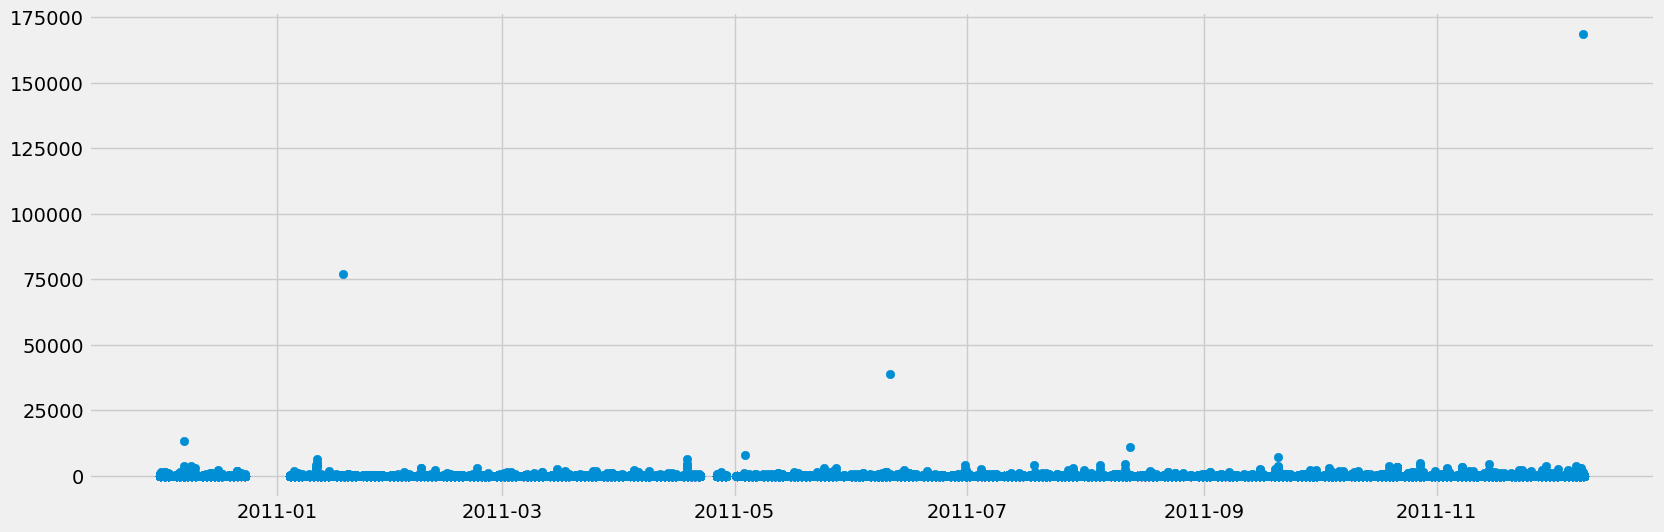

In [ ]:
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['Sales'])

Let's remove obvious outliers

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

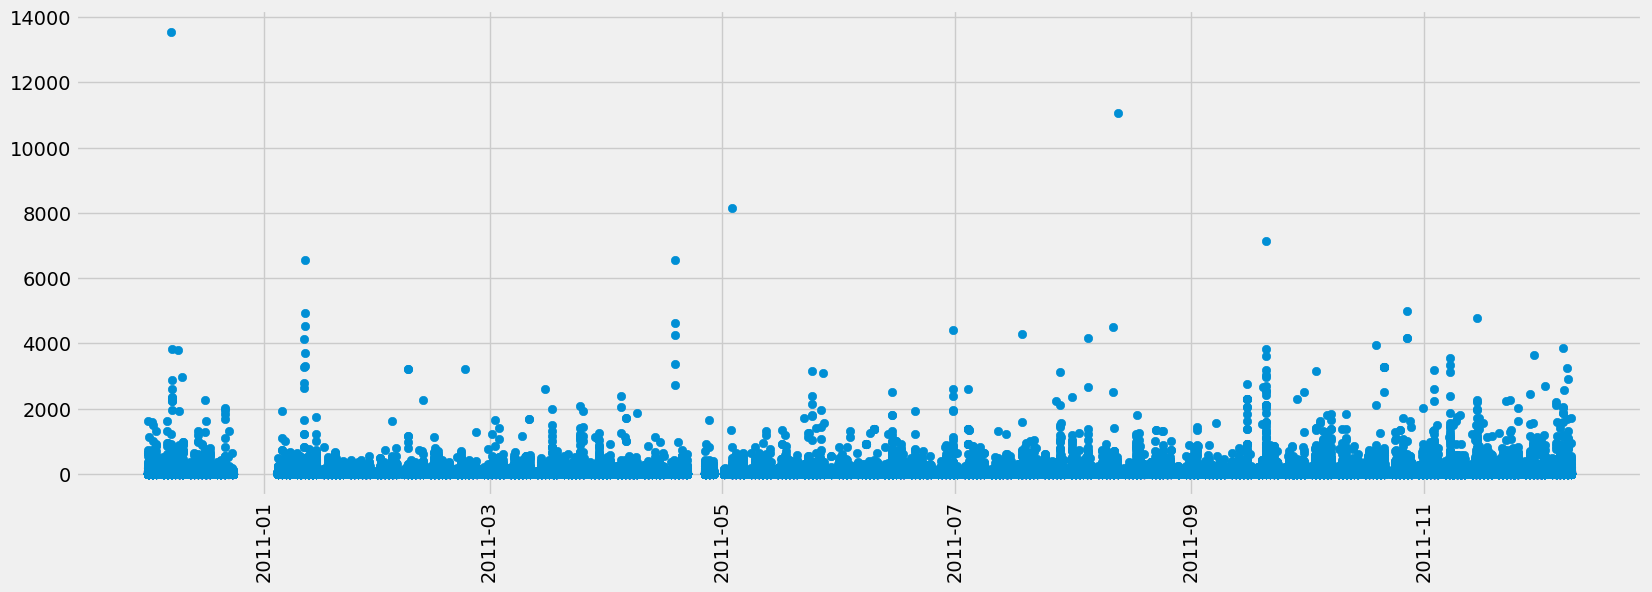

In [ ]:
df = df[df['Sales'] < 25000]
plt.figure(figsize=(18,6))
plt.scatter(x=df.index, y=df['Sales'])
plt.xticks(rotation=90)

After removing obvious outliers we still see some values that are out of normal distribution. To understand better the distribution of our data let's check out different percentiles of our numeric features.

In [ ]:
df.quantile([0.05, 0.95, 0.98, 0.99, 0.999])

,Quantity,UnitPrice,Sales
0.050,1.0,0.42,1.25
0.950,30.0,9.95,59.70
0.980,72.0,14.95,121.68
0.990,100.0,16.98,183.60
0.999,446.4,165.00,833.79


We can see that if we remove top 2% of our data points we will get rid of absolute outliers and will have more balaced dataset.

(array([14975., 15034., 15095., 15156., 15218., 15279.]),
 [Text(14975.0, 0, '2011-01'),
  Text(15034.0, 0, '2011-03'),
  Text(15095.0, 0, '2011-05'),
  Text(15156.0, 0, '2011-07'),
  Text(15218.0, 0, '2011-09'),
  Text(15279.0, 0, '2011-11')])

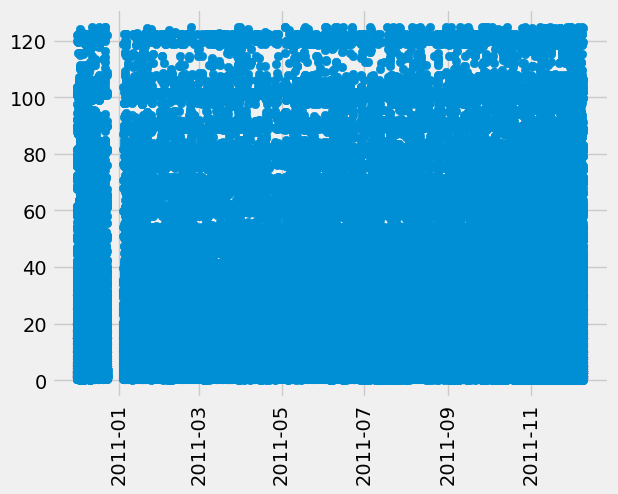

In [ ]:
df_quantile = df[df['Sales'] < 125]
plt.scatter(x=df_quantile.index, y=df_quantile['Sales'])
plt.xticks(rotation=90)

In [ ]:
df_quantile.describe()

,Quantity,UnitPrice,Sales
count,519958.000000,519958.000000,519958.000000
mean,7.850934,3.286582,13.850263
std,15.303867,3.949021,16.330954
min,1.000000,0.001000,0.001000
25%,1.000000,1.250000,3.750000
50%,3.000000,2.080000,9.840000
75%,10.000000,4.130000,17.220000
max,1600.000000,124.870000,124.950000


Looks like our data is almost ready for modelling. We performed a clean up, we removed outliers that were disturbing the balance of our dataset, we removed invalid records - now our data looks much better! and it doesn't lose it's value.

## 3.2. Visually checking distribution of numeric features

<Axes: ylabel='Density'>

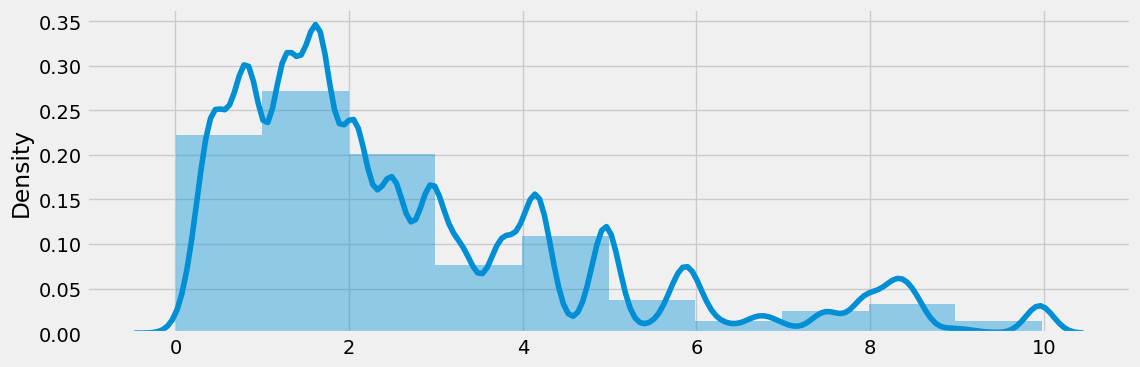

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 10]['UnitPrice'].values, kde=True, bins=10)

<Axes: ylabel='Density'>

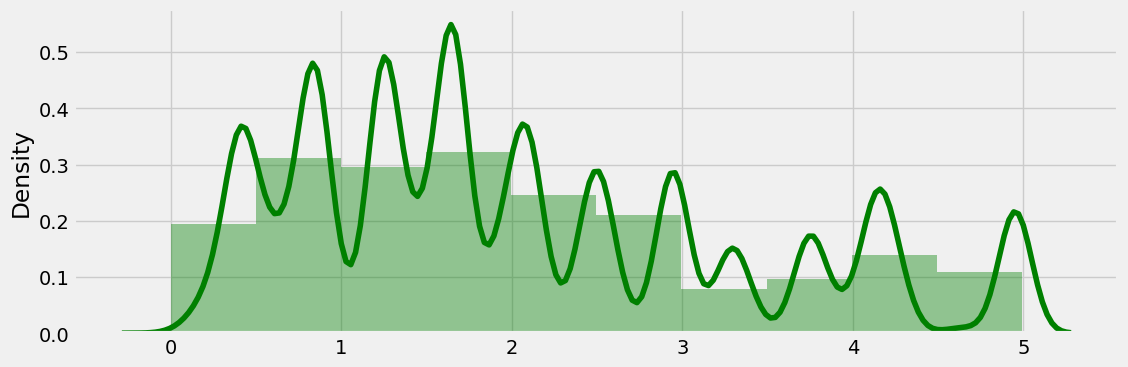

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['UnitPrice'] < 5]['UnitPrice'].values, kde=True, bins=10, color='green')

From these histograms we can see that vast majority of items sold in this store has low price range - 0 to 3 pounds.

<Axes: xlabel='Quantity', ylabel='Density'>

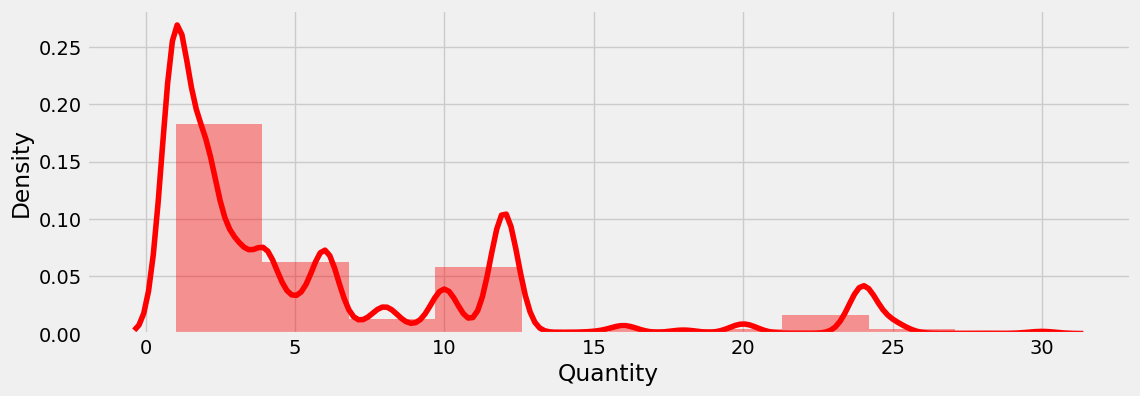

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 30]['Quantity'], kde=True, bins=10, color='red')

<Axes: xlabel='Quantity', ylabel='Density'>

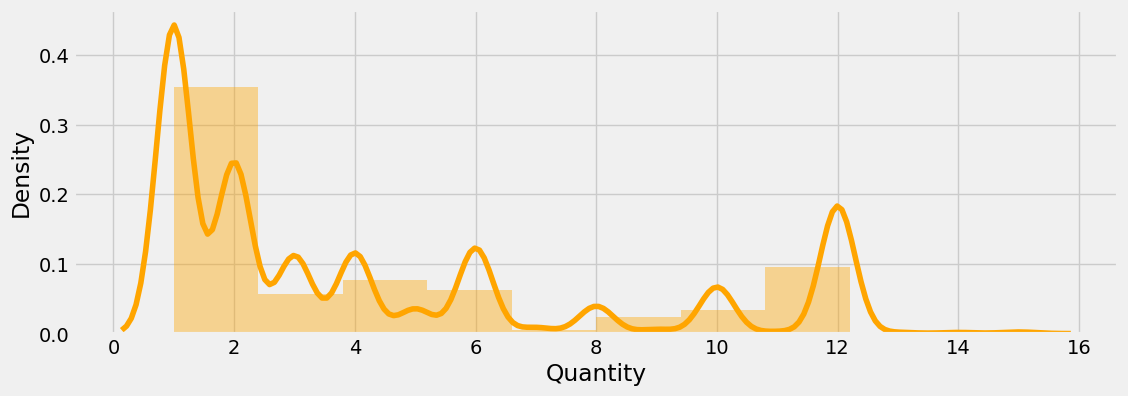

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Quantity'] <= 15]['Quantity'], kde=True, bins=10, color='orange')

From these histograms we that people bought normally 1-5 items or 10-12 - maybe there were some kind of offers for sets?

<Axes: xlabel='Sales', ylabel='Density'>

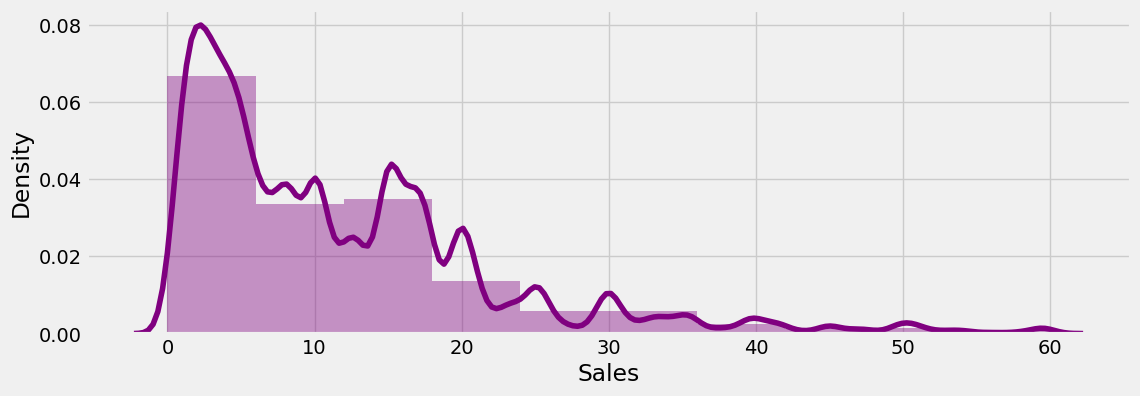

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Sales'] < 60]['Sales'], kde=True, bins=10, color='purple')

<Axes: xlabel='Sales', ylabel='Density'>

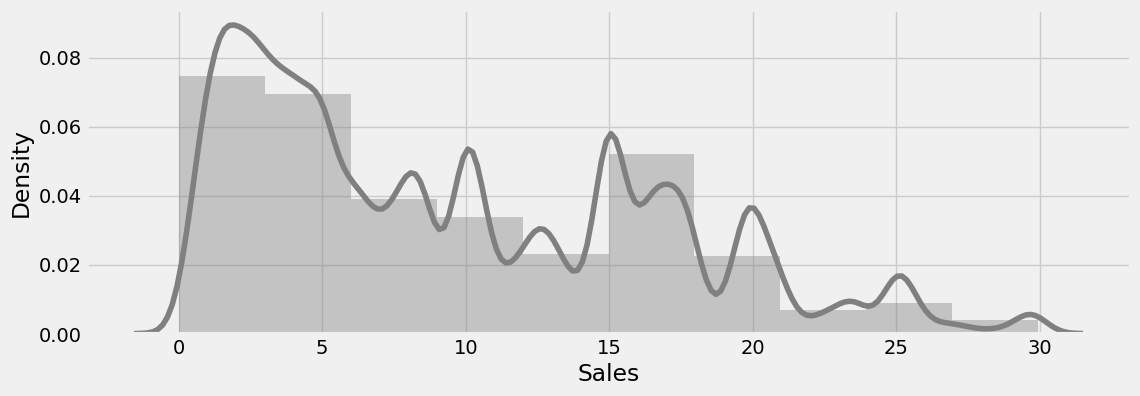

In [ ]:
plt.figure(figsize=(12,4))
sns.distplot(df_quantile[df_quantile['Sales'] < 30]['Sales'], kde=True, bins=10, color='grey')

From these histograms we can understand that majority of sales per order were in range 1-15 pounds each.

## 3.3. Analysing sales over time

In [ ]:
df_ts = df[['Sales']]
df_ts.head()

,Sales
InvoiceDate,
2010-12-01 08:26:00,15.30
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,22.00
2010-12-01 08:26:00,20.34
2010-12-01 08:26:00,20.34


As we can see every invoice has it's own timestamp (definitely based on time the order was made). We can resample time data by, for example weeks, and try see if there is any patterns in our sales.

<Axes: xlabel='InvoiceDate'>

<Figure size 1800x600 with 0 Axes>

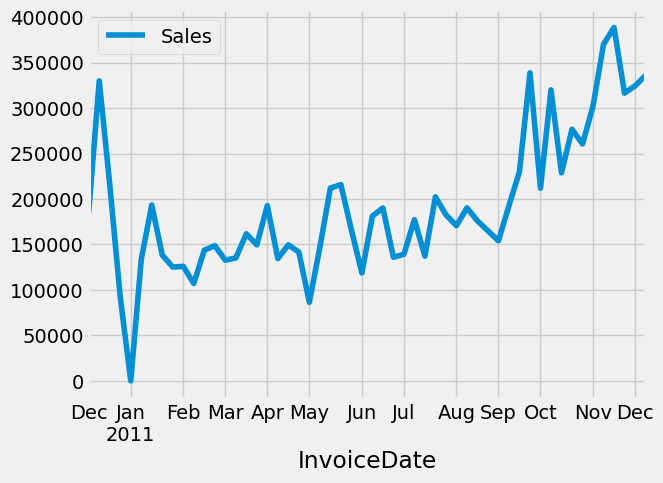

In [ ]:
plt.figure(figsize=(18,6))
df_resample = df_ts.resample('W').sum()
df_resample.plot()

That week with 0 sales in January looks suspicious, let's check it closer

In [ ]:
df_resample['12-2010':'01-2011']

,Sales
InvoiceDate,
2010-12-05,185427.83
2010-12-12,329936.81
2010-12-19,216012.20
2010-12-26,92369.30
2011-01-02,0.00
2011-01-09,133658.19
2011-01-16,193362.04
2011-01-23,138349.58
2011-01-30,125170.79


Now it makes sense - possibly, during the New Year holidays period the store was closed and didn't process orders, that's why they didn't make any sales.

# 4. Preparing data for modeling and feature creation

Now it comes the most fun part of the project - building a model. To do this we will need to create few more additional features to make our model more sophisticated.

In [ ]:
df_clean = df[df['UnitPrice'] < 15]
df_clean.describe()

,Quantity,UnitPrice,Sales
count,520393.000000,520393.000000,520393.000000
mean,10.409364,2.978735,18.669870
std,38.123726,2.669829,64.710055
min,1.000000,0.001000,0.001000
25%,1.000000,1.250000,3.750000
50%,4.000000,2.080000,9.840000
75%,12.000000,4.130000,17.400000
max,4800.000000,14.960000,7144.720000


In [ ]:
df_clean.index

DatetimeIndex(['2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:26:00',
               '2010-12-01 08:26:00', '2010-12-01 08:28:00',
               '2010-12-01 08:28:00', '2010-12-01 08:34:00',
               ...
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00',
               '2011-12-09 12:50:00', '2011-12-09 12:50:00'],
              dtype='datetime64[ns]', name='InvoiceDate', length=520393, freq=None)

## 4.1. Quantity per invoice feature

A feature that could influence the sales output could be "Quantity per invoice". Let's find the data for this feature.

In [ ]:
df_join = df_clean.groupby('InvoiceNo')[['Quantity']].sum()

In [ ]:
df_join = df_join.reset_index()
df_join.head()

,InvoiceNo,Quantity
0,536365,40
1,536366,12
2,536367,83
3,536368,15
4,536369,3


In [ ]:
df_clean['InvoiceDate'] = df_clean.index
df_clean = df_clean.merge(df_join, how='left', on='InvoiceNo')
df_clean = df_clean.rename(columns={'Quantity_x' : 'Quantity', 'Quantity_y' : 'QuantityInv'})
df_clean.tail(15)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv
520378,581587,22631,CIRCUS PARADE LUNCH BOX,12,1.95,France,23.40,2011-12-09 12:50:00,105
520379,581587,22556,PLASTERS IN TIN CIRCUS PARADE,12,1.65,France,19.80,2011-12-09 12:50:00,105
520380,581587,22555,PLASTERS IN TIN STRONGMAN,12,1.65,France,19.80,2011-12-09 12:50:00,105
520381,581587,22728,ALARM CLOCK BAKELIKE PINK,4,3.75,France,15.00,2011-12-09 12:50:00,105
520382,581587,22727,ALARM CLOCK BAKELIKE RED,4,3.75,France,15.00,2011-12-09 12:50:00,105
520383,581587,22726,ALARM CLOCK BAKELIKE GREEN,4,3.75,France,15.00,2011-12-09 12:50:00,105
520384,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,3.75,France,15.00,2011-12-09 12:50:00,105
520385,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,1.95,France,15.60,2011-12-09 12:50:00,105
520386,581587,22629,SPACEBOY LUNCH BOX,12,1.95,France,23.40,2011-12-09 12:50:00,105
520387,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,4.15,France,16.60,2011-12-09 12:50:00,105


In [ ]:
df_clean.describe()

,Quantity,UnitPrice,Sales,QuantityInv
count,520393.000000,520393.000000,520393.000000,520393.000000
mean,10.409364,2.978735,18.669870,533.328732
std,38.123726,2.669829,64.710055,890.339855
min,1.000000,0.001000,0.001000,1.000000
25%,1.000000,1.250000,3.750000,152.000000
50%,4.000000,2.080000,9.840000,300.000000
75%,12.000000,4.130000,17.400000,567.000000
max,4800.000000,14.960000,7144.720000,15049.000000


In [ ]:
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

In [ ]:
df_clean.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
UnitPrice             float64
Country                object
Sales                 float64
InvoiceDate    datetime64[ns]
QuantityInv             int64
dtype: object

## 4.2. Bucketizing Quantity and UnitPrice features

Based on the EDA done previously we can group these features into 6 buckets for Quantity and 5 for UnitePrice using pandas .cut() method.

In [ ]:
bins_q = pd.IntervalIndex.from_tuples([(0, 2), (2, 5), (5, 8), (8, 11), (11, 14), (15, 5000)])
df_clean['QuantityRange'] = pd.cut(df_clean['Quantity'], bins=bins_q)
bins_p = pd.IntervalIndex.from_tuples([(0, 1), (1, 2), (2, 3), (3, 4), (4, 20)])
df_clean['PriceRange'] = pd.cut(df_clean['UnitPrice'], bins=bins_p)
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]"


## 4.3. Extracting and bucketizing dates

We have noticed that depends on a season gifts sell differently: pick of sales is in the Q4, then it drastically drops in Q1 of the next year and continues to grow till its new pick in Q4 again. From this observation we can create another feature that could improve our model.

In [ ]:
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12


In [ ]:
bins_d = pd.IntervalIndex.from_tuples([(0,3),(3,6),(6,9),(9,12)])
df_clean['DateRange'] = pd.cut(df_clean['Month'], bins=bins_d, labels=['q1','q2','q3','q4'])
df_clean.tail()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
520388,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,0.85,France,10.20,2011-12-09 12:50:00,105,"(11, 14]","(0, 1]",12,"(9, 12]"
520389,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2.10,France,12.60,2011-12-09 12:50:00,105,"(5, 8]","(2, 3]",12,"(9, 12]"
520390,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,4.15,France,16.60,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"
520391,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,4.15,France,16.60,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"
520392,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,4.95,France,14.85,2011-12-09 12:50:00,105,"(2, 5]","(4, 20]",12,"(9, 12]"


# 5. Building a model

## 5.1. Splitting data into UK and non-UK

We have to analyze these 2 datasets separately to have more standardized data for a model, because there can be some patterns that work for other countries and do not for UK or vise versa. Also a hypothesis to test - does the model built for UK performs good on data for other countries?

In [ ]:
df_uk = df_clean[df_clean['Country'] == 'United Kingdom']
df_abroad = df_clean[df_clean['Country'] != 'United Kingdom']

In [ ]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,Country,Sales,InvoiceDate,QuantityInv,QuantityRange,PriceRange,Month,DateRange
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,United Kingdom,15.30,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
1,536365,71053,WHITE METAL LANTERN,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,United Kingdom,22.00,2010-12-01 08:26:00,40,"(5, 8]","(2, 3]",12,"(9, 12]"
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,United Kingdom,20.34,2010-12-01 08:26:00,40,"(5, 8]","(3, 4]",12,"(9, 12]"


## 5.2. Extracting features and creating dummy variables

In [ ]:
df_uk_model = df_uk[['Sales', 'QuantityInv', 'QuantityRange', 'PriceRange', 'DateRange']]
df_uk_model.head()

,Sales,QuantityInv,QuantityRange,PriceRange,DateRange
0,15.30,40,"(5, 8]","(2, 3]","(9, 12]"
1,20.34,40,"(5, 8]","(3, 4]","(9, 12]"
2,22.00,40,"(5, 8]","(2, 3]","(9, 12]"
3,20.34,40,"(5, 8]","(3, 4]","(9, 12]"
4,20.34,40,"(5, 8]","(3, 4]","(9, 12]"


In [ ]:
df_data = df_uk_model.copy()
df_data = pd.get_dummies(df_data, columns=['QuantityRange'], prefix='qr')
df_data = pd.get_dummies(df_data, columns=['PriceRange'], prefix='pr')
df_data = pd.get_dummies(df_data, columns=['DateRange'], prefix='dr')
df_data.head()

,Sales,QuantityInv,"qr_(0, 2]","qr_(2, 5]","qr_(5, 8]","qr_(8, 11]","qr_(11, 14]","qr_(15, 5000]","pr_(0, 1]","pr_(1, 2]","pr_(2, 3]","pr_(3, 4]","pr_(4, 20]","dr_(0, 3]","dr_(3, 6]","dr_(6, 9]","dr_(9, 12]"
0,15.30,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,20.34,40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,22.00,40,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,20.34,40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,20.34,40,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1


## 5.3. Scaling

As the majority of our features are in 0-1 range it would make sense to scale "QuantityInv" feature too. In general, scaling features is normally a good idea.

In [ ]:
from sklearn.preprocessing import scale
df_data['QuantityInv'] = scale(df_data['QuantityInv'])

## 5.4. Train-Test Split

Now we have to split our data into train-test data to be able to train our model and validate its capabilities.

In [ ]:
y = df_data['Sales']
X = df_data.drop(columns=['Sales'])

In [ ]:
X.shape

(476972, 16)

In [ ]:
y.shape

(476972,)

In [ ]:
x_train = X.iloc[0:381577] # 80%
x_test = X.iloc[381577:] # 20%
y_train = y.iloc[0:381577] # 80%
y_test = y.iloc[381577:] # 20%

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(381577, 16)
(95395, 16)
(381577,)
(95395,)


In [ ]:
x_train.head(100)

,QuantityInv,"qr_(0, 2]","qr_(2, 5]","qr_(5, 8]","qr_(8, 11]","qr_(11, 14]","qr_(15, 5000]","pr_(0, 1]","pr_(1, 2]","pr_(2, 3]","pr_(3, 4]","pr_(4, 20]","dr_(0, 3]","dr_(3, 6]","dr_(6, 9]","dr_(9, 12]"
0,-0.664213,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
1,-0.664213,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,-0.664213,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,-0.664213,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
4,-0.664213,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-0.430691,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
115,-0.430691,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
116,-0.430691,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1
117,-0.430691,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1


In [ ]:
import numpy as np

x_train = np.asarray(x_train).astype(np.float32)
x_test = np.asarray(x_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [ ]:
mea = np.mean(x_train,axis = 0)
std = np.std(x_train,axis = 0)
x_train = (x_train-mea)/std
x_test = (x_test-mea)/std

In [ ]:
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential

LSTM starts

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError

def preprocess_data(x, y):
    # Handle missing values
    x = np.nan_to_num(x, nan=0.0)
    y = np.nan_to_num(y, nan=0.0)

    # Normalize input features
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    x = (x - x_mean) / x_std

    # Normalize target variable
    y_mean = np.mean(y)
    y_std = np.std(y)
    y = (y - y_mean) / y_std

    return x, y, x_mean, x_std, y_mean, y_std

def get_transformer_model(params, input_shape):
    inputs = Input(shape=(input_shape,))

    x = inputs
    x = tf.expand_dims(x, axis=-1)  # Add a channel dimension for compatibility with Conv1D
    x = Masking(mask_value=0.0)(x)  # Mask zero values

    # Rest of the model definition...
    # Modify the model architecture as needed based on your requirements

    model = Model(inputs=inputs, outputs=x)

    return model

params = {
    "num_layers": 4,
    "d_model": 64,
    "num_heads": 8,
    "d_ff": 256,
    "dropout": 0.3,
    "learning_rate": 0.001,
    "epochs": 200,
    "batch_size": 32,
    "es_patience": 15
}

# Preprocess the data
x_train_processed, y_train_processed, x_train_mean, x_train_std, y_train_mean, y_train_std = preprocess_data(x_train, y_train)
x_test_processed, y_test_processed, x_test_mean, x_test_std, y_test_mean, y_test_std = preprocess_data(x_test, y_test)

# Create the model
model = get_transformer_model(params=params, input_shape=x_train.shape[1])

# Compile the model
model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=params["learning_rate"]),
    metrics=[RootMeanSquaredError(), MeanAbsoluteError()]
)

# Define early stopping callback
es_callback = EarlyStopping(monitor='val_loss', patience=params['es_patience'], restore_best_weights=True)

# Train the model
history = model.fit(
    x_train_processed,
    y_train_processed,
    validation_data=(x_test_processed, y_test_processed),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1,
    callbacks=[es_callback]
)


Epoch 1/200
11925/11925 [==============================] - 24s 2ms/step - loss: 1.9988 - root_mean_squared_error: 1.4138 - mean_absolute_error: 0.7679 - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/200
11925/11925 [==============================] - 24s 2ms/step - loss: 1.9988 - root_mean_squared_error: 1.4138 - mean_absolute_error: 0.7679 - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/200
11925/11925 [==============================] - 22s 2ms/step - loss: 1.9988 - root_mean_squared_error: 1.4138 - mean_absolute_error: 0.7679 - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/200
11925/11925 [==============================] - 23s 2ms/step - loss: 1.9989 - root_mean_squared_error: 1.4138 - mean_absolute_error: 0.7679 - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/200
11925/11925 [==============================] - 24s 2ms/s

In [ ]:
print(history.history)

{'loss': [1.9988162517547607, 1.998826265335083, 1.9988073110580444, 1.9988806247711182, 1.9987876415252686, 1.998759150505066, 1.9987214803695679, 1.9987155199050903, 1.9988259077072144, 1.9987645149230957, 1.9988548755645752, 1.9989190101623535, 1.9987435340881348, 1.998740792274475, 1.9987772703170776], 'root_mean_squared_error': [1.413800597190857, 1.4138020277023315, 1.4137972593307495, 1.4138214588165283, 1.413788080215454, 1.4137789011001587, 1.413766860961914, 1.4137661457061768, 1.4138023853302002, 1.413781762123108, 1.413814663887024, 1.4138367176055908, 1.4137722253799438, 1.413774013519287, 1.4137877225875854], 'mean_absolute_error': [0.7678799033164978, 0.7678806185722351, 0.7678776979446411, 0.7678857445716858, 0.7678760886192322, 0.7678713798522949, 0.7678776383399963, 0.7678676843643188, 0.7678807973861694, 0.7678742408752441, 0.7678799629211426, 0.7678870558738708, 0.7678756713867188, 0.7678731083869934, 0.7678759694099426], 'val_loss': [nan, nan, nan, nan, nan, nan, n

In [ ]:
root_mean_squared_error = history.history['root_mean_squared_error']
mean_absolute_error = history.history['mean_absolute_error']
val_loss = history.history['val_loss']
val_root_mean_squared_error = history.history['val_root_mean_squared_error']
val_mean_absolute_error = history.history['val_mean_absolute_error']

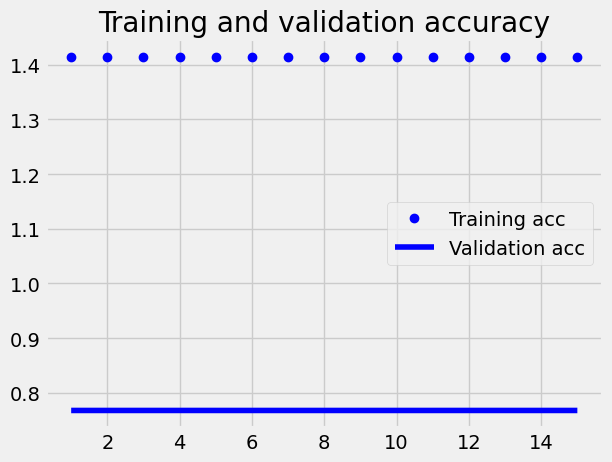

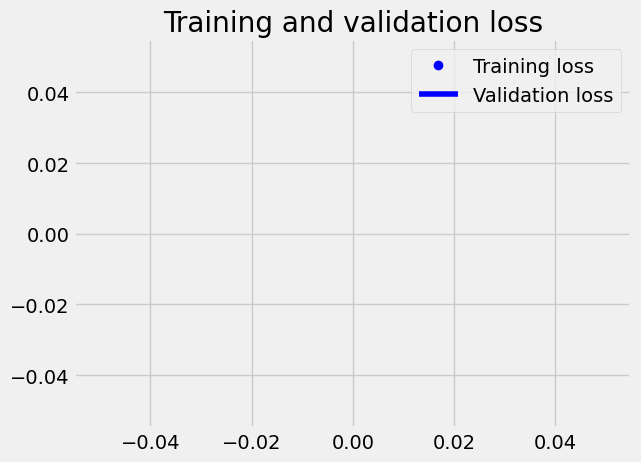

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_loss) + 1)

plt.plot(epochs, root_mean_squared_error, 'bo', label='Training acc')
plt.plot(epochs, mean_absolute_error, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, val_root_mean_squared_error, 'bo', label='Training loss')
plt.plot(epochs, val_mean_absolute_error, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Dropout, Masking
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError

def preprocess_data(x, y):
    # Handle missing values
    x = np.nan_to_num(x, nan=0.0)
    y = np.nan_to_num(y, nan=0.0)

    # Normalize input features
    x_mean = np.mean(x, axis=0)
    x_std = np.std(x, axis=0)
    x = (x - x_mean) / x_std

    # Normalize target variable
    y_mean = np.mean(y)
    y_std = np.std(y)
    y = (y - y_mean) / y_std

    return x, y, x_mean, x_std, y_mean, y_std

def get_wavenet_model(params, input_shape):
    inputs = Input(shape=(input_shape, 1))  # Add a channel dimension

    x = inputs
    x = Masking(mask_value=0.0)(x)  # Mask zero values

    # WaveNet layers
    for dilation_rate in params['dilation_rates']:
        x_residual = x

        # Dilated convolution
        x = Conv1D(filters=params['num_filters'], kernel_size=params['kernel_size'], padding='causal', dilation_rate=dilation_rate, activation='relu')(x)
        x = Dropout(params['dropout'])(x)

        # Skip connection
        x = tf.keras.layers.add([x, x_residual])

    # Final output layer
    x = Conv1D(filters=1, kernel_size=1)(x)

    model = Model(inputs=inputs, outputs=x)

    return model

params = {
    "dilation_rates": [1, 2, 4, 8],
    "num_filters": 32,
    "kernel_size": 2,
    "dropout": 0.3,
    "learning_rate": 0.001,
    "epochs": 200,
    "batch_size": 32,
    "es_patience": 15
}

# Preprocess the data
x_train_processed, y_train_processed, x_train_mean, x_train_std, y_train_mean, y_train_std = preprocess_data(x_train, y_train)
x_test_processed, y_test_processed, x_test_mean, x_test_std, y_test_mean, y_test_std = preprocess_data(x_test, y_test)

# Reshape the input data
x_train_processed = np.expand_dims(x_train_processed, axis=-1)
x_test_processed = np.expand_dims(x_test_processed, axis=-1)

# Create the model
model = get_wavenet_model(params=params, input_shape=x_train_processed.shape[1])

# Compile the model
model.compile(
    loss=MeanSquaredError(),
    optimizer=Adam(learning_rate=params["learning_rate"]),
    metrics=[RootMeanSquaredError(), MeanAbsoluteError()]
)

# Define early stopping callback
es_callback = EarlyStopping(monitor='val_loss', patience=params['es_patience'], restore_best_weights=True)

# Train the model
history = model.fit(
    x_train_processed,
    y_train_processed,
    validation_data=(x_test_processed, y_test_processed),
    epochs=params["epochs"],
    batch_size=params["batch_size"],
    verbose=1,
    callbacks=[es_callback]
)


Epoch 1/200
11925/11925 [==============================] - 100s 8ms/step - loss: 1.0087 - root_mean_squared_error: 1.0044 - mean_absolute_error: 0.2541 - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 2/200
11925/11925 [==============================] - 100s 8ms/step - loss: 1.0003 - root_mean_squared_error: 1.0002 - mean_absolute_error: 0.2482 - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 3/200
11925/11925 [==============================] - 93s 8ms/step - loss: 1.0003 - root_mean_squared_error: 1.0001 - mean_absolute_error: 0.2481 - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 4/200
11925/11925 [==============================] - 93s 8ms/step - loss: 1.0002 - root_mean_squared_error: 1.0001 - mean_absolute_error: 0.2480 - val_loss: nan - val_root_mean_squared_error: nan - val_mean_absolute_error: nan
Epoch 5/200
11925/11925 [==============================] - 93s 8ms

In [ ]:
print(history.history)

{'loss': [1.0087331533432007, 1.0003368854522705, 1.000259518623352, 1.0002449750900269, 1.0002020597457886, 1.000196933746338, 1.000138521194458, 1.0001521110534668, 1.0001581907272339, 1.0001332759857178, 1.0001510381698608, 1.0001417398452759, 1.000126600265503, 1.0001417398452759, 1.000084638595581], 'root_mean_squared_error': [1.0043654441833496, 1.0001766681671143, 1.0001369714736938, 1.0001296997070312, 1.0001091957092285, 1.000106692314148, 1.000077247619629, 1.0000834465026855, 1.0000873804092407, 1.0000747442245483, 1.0000838041305542, 1.0000789165496826, 1.0000715255737305, 1.0000790357589722, 1.0000505447387695], 'mean_absolute_error': [0.2540768086910248, 0.24823889136314392, 0.2481193244457245, 0.2479851245880127, 0.248120978474617, 0.2480172961950302, 0.24794958531856537, 0.24793528020381927, 0.2479095607995987, 0.2481294572353363, 0.2477569878101349, 0.24790272116661072, 0.24775898456573486, 0.24811004102230072, 0.24794921278953552], 'val_loss': [nan, nan, nan, nan, nan

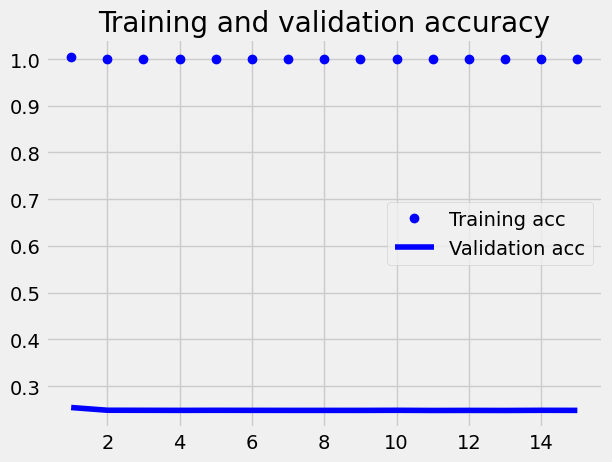

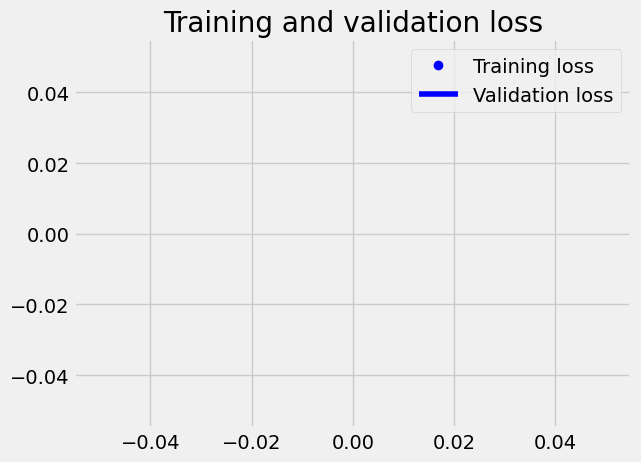

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_loss) + 1)


plt.plot(epochs, root_mean_squared_error, 'bo', label='Training acc')
plt.plot(epochs, mean_absolute_error, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, val_root_mean_squared_error, 'bo', label='Training loss')
plt.plot(epochs, val_mean_absolute_error, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
root_mean_squared_error = history.history['root_mean_squared_error']
mean_absolute_error = history.history['mean_absolute_error']
val_loss = history.history['val_loss']
val_root_mean_squared_error = history.history['val_root_mean_squared_error']
val_mean_absolute_error = history.history['val_mean_absolute_error']

In [ ]:
def get_model(params, input_shape):
	model = Sequential()
	model.add(LSTM(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 1)))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(LSTM(units=params["lstm_units"], return_sequences=False))
	model.add(Dropout(rate=params["dropout"]))

	model.add(Dense(1,activation = "linear"))

	model.compile(loss=params["loss"],
              	optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.003),
              	metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

	return model

In [ ]:
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
	"dropout": 0.3,
	"lstm_units": 64,
	"epochs": 152,
	"batch_size": 32,
	"es_patience" : 15
}

model = get_model(params=params, input_shape=x_train.shape[1])

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min',
patience=params["es_patience"])

In [ ]:
history = model.fit(
	x_train,
	y_train,
	validation_data=(x_test, y_test),
	epochs=params["epochs"],
	batch_size=params["batch_size"],
	verbose=1, callbacks=[es_callback]
)

GRU

In [ ]:
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from keras.layers import GRU
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential

In [ ]:
def get_model(params, input_shape):
	model = Sequential()
	model.add(GRU(units=params["gru_units"], return_sequences=True, input_shape=(input_shape, 1)))
	model.add(Dropout(rate=params["dropout"]))

	model.add(GRU(units=params["gru_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(GRU(units=params["gru_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(GRU(units=params["gru_units"], return_sequences=False))
	model.add(Dropout(rate=params["dropout"]))

	model.add(Dense(1,activation = "linear"))

	model.compile(loss=params["loss"],
              	optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.003),
              	metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

	return model

In [ ]:
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
	"dropout": 0.2,
	"gru_units": 138,
	"epochs": 100,
	"batch_size": 128,
	"es_patience" : 10
}

model = get_model(params=params, input_shape=x_train.shape[1])

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min',
patience=params["es_patience"])

In [ ]:
history = model.fit(
	x_train,
	y_train,
	validation_data=(x_test, y_test),
	epochs=params["epochs"],
	batch_size=params["batch_size"],
	verbose=1, callbacks=[es_callback]
)

In [ ]:
root_mean_squared_error = history.history['root_mean_squared_error']
mean_absolute_error = history.history['mean_absolute_error']
val_loss = history.history['val_loss']
val_root_mean_squared_error = history.history['val_root_mean_squared_error']
val_mean_absolute_error = history.history['val_mean_absolute_error']

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_loss) + 1)

plt.plot(epochs, root_mean_squared_error, 'bo', label='Training acc')
plt.plot(epochs, mean_absolute_error, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, val_root_mean_squared_error, 'bo', label='Training loss')
plt.plot(epochs, val_mean_absolute_error, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

RNN

In [ ]:
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential

In [ ]:
def get_model(params, input_shape):
	model = Sequential()
	model.add(SimpleRNN(units=params["lstm_units"], return_sequences=True, input_shape=(input_shape, 1)))
	model.add(Dropout(rate=params["dropout"]))

	model.add(SimpleRNN(units=params["lstm_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(SimpleRNN(units=params["lstm_units"], return_sequences=True))
	model.add(Dropout(rate=params["dropout"]))

	model.add(SimpleRNN(units=params["lstm_units"], return_sequences=False))
	model.add(Dropout(rate=params["dropout"]))

	model.add(Dense(1,activation = "linear"))

	model.compile(loss=params["loss"],
              	optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.003),
              	metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

	return model

In [ ]:
params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
	"dropout": 0.2,
	"lstm_units": 138,
	"epochs": 100,
	"batch_size": 128,
	"es_patience" : 10
}

model = get_model(params=params, input_shape=x_train.shape[1])

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min',
patience=params["es_patience"])

In [ ]:
history = model.fit(
	x_train,
	y_train,
	validation_data=(x_test, y_test),
	epochs=params["epochs"],
	batch_size=params["batch_size"],
	verbose=1, callbacks=[es_callback]
)

In [ ]:
root_mean_squared_error = history.history['root_mean_squared_error']
mean_absolute_error = history.history['mean_absolute_error']
val_loss = history.history['val_loss']
val_root_mean_squared_error = history.history['val_root_mean_squared_error']
val_mean_absolute_error = history.history['val_mean_absolute_error']

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_loss) + 1)

plt.plot(epochs, root_mean_squared_error, 'bo', label='Training acc')
plt.plot(epochs, mean_absolute_error, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, val_root_mean_squared_error, 'bo', label='Training loss')
plt.plot(epochs, val_mean_absolute_error, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

CNN

In [ ]:
import tensorflow as tf
from keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential

In [ ]:
def CNN_model(params):

  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                        strides=1, padding="causal",
                        activation="relu",
                        input_shape=[None, 1]),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(filters=32, kernel_size=32,
                        strides=1, padding="causal",
                        activation="relu"),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(1,activation = "linear")])
    #tf.keras.layers.Lambda(lambda x: x * 200)

  model.compile(loss=params["loss"],
              optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.003),
              metrics=[RootMeanSquaredError(), MeanAbsoluteError()])

  return model


params = {
	"loss": "mean_squared_error",
	"optimizer": "adam",
	"dropout": 0.2,
	"epochs": 100,
	"batch_size": 128,
	"es_patience" : 10
}

model = CNN_model(params)

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_root_mean_squared_error',
                                           	mode='min',
patience=params["es_patience"])


history_cnn = model.fit(
	x_train,
	y_train,
	validation_data=(x_test, y_test),
	epochs=params["epochs"],
	batch_size=params["batch_size"],
	verbose=1, callbacks=[es_callback]
)

In [ ]:
root_mean_squared_error = history_cnn.history['root_mean_squared_error']
mean_absolute_error = history_cnn.history['mean_absolute_error']
val_loss = history_cnn.history['val_loss']
val_root_mean_squared_error = history_cnn.history['val_root_mean_squared_error']
val_mean_absolute_error = history_cnn.history['val_mean_absolute_error']

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_loss) + 1)

plt.plot(epochs, root_mean_squared_error, 'bo', label='Training acc')
plt.plot(epochs, mean_absolute_error, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, val_root_mean_squared_error, 'bo', label='Training loss')
plt.plot(epochs, val_mean_absolute_error, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()